In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
import matplotlib.animation as animation
from IPython.display import HTML, Image

from tensorflow.keras.models import load_model
import tensorflow as tf


import pydot
from IPython.display import Image, display
import imageio

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [3]:
from Env.Simulator_New import Simulator
param_model = load_model("param_model.h5")
dqn_model = load_model("dqn_model.h5")
from tester import Tester
reward_data = np.loadtxt("rewards.csv", delimiter = ",")

Add action: sell stream ?


In [4]:
tester = Tester(param_model, dqn_model, Simulator())
env = tester.test()
env.column_streams

stream [9.09988284e-01 6.79320009e+02 9.10000000e+02 6.80000000e+02
 6.80000000e+02 6.80000000e+02] is seperated with an LK of 0 with a split of [0.99900001]
stream [9.09976568e-04 6.78640697e+02 9.10000000e+02 6.80000000e+02
 6.80000000e+02 6.80000000e+02] is seperated with an LK of 0 with a split of [0.99900001]
stream [9.09964853e-07 6.77962066e+02 9.10000000e+02 6.80000000e+02
 6.80000000e+02 6.80000000e+02] is seperated with an LK of 0 with a split of [0.99900001]
stream [9.09953137e-10 6.77284112e+02 9.10000000e+02 6.80000000e+02
 6.80000000e+02 6.80000000e+02] is seperated with an LK of 0 with a split of [0.99900001]
stream [9.09941422e-13 6.76606837e+02 9.10000000e+02 6.80000000e+02
 6.80000000e+02 6.80000000e+02] is seperated with an LK of 0 with a split of [0.99900001]
stream [9.09929707e-16 6.75930239e+02 9.10000000e+02 6.80000000e+02
 6.80000000e+02 6.80000000e+02] is seperated with an LK of 0 with a split of [0.99900001]
stream [9.09917992e-19 6.75254317e+02 9.10000000e+02

[(0, 1, 2),
 (2, 3, 4),
 (4, 5, 6),
 (6, 7, 8),
 (8, 9, 10),
 (10, 11, 12),
 (12, 13, 14),
 (14, 15, 16),
 (16, 17, 18),
 (18, 19, 20),
 (20, 21, 22),
 (22, 23, 24),
 (24, 25, 26)]

In [5]:
env.column_conditions

[[7853.398787855702, array([60.06420557]), array([171.23151583])],
 [5609.967842127102, array([76.17470931]), array([144.62159046])],
 [2609.5030184299453, array([60.09076182]), array([94.56780684])],
 [2602.4803027879493, array([60.00009114]), array([94.42220432])],
 [2602.4732637165403, array([60.00000009]), array([94.43119087])],
 [2602.473256670504, array([60.]), array([94.44032826])],
 [2602.4732566634507, array([60.]), array([94.44946152])],
 [2602.473256663444, array([60.]), array([94.4585905])],
 [2602.473256663444, array([60.]), array([94.46771521])],
 [2602.473256663444, array([60.]), array([94.47683563])],
 [2602.473256663444, array([60.]), array([94.48595178])],
 [2602.473256663444, array([60.]), array([94.49506364])],
 [2602.473256663444, array([60.]), array([94.50417121])]]

In [6]:
env.column_dimensions

[[array([27.35472865]), 20.83159196197951],
 [array([26.92555261]), 4371561.958362837],
 [array([24.2880987]), 20183112.19395106],
 [array([24.27830109]), 20256498.498967655],
 [array([24.27863772]), 20290009.42270973],
 [array([24.27898434]), 20323541.50515821],
 [array([24.27933081]), 20357134.8998023],
 [array([24.27967711]), 20390789.763868038],
 [array([24.28002324]), 20424506.21470819],
 [array([24.28036919]), 20458284.36986433],
 [array([24.28071497]), 20492124.347107556],
 [array([24.28106059]), 20526026.26443908],
 [array([24.28140603]), 20559990.2400906]]

In [24]:
def find_column(stream):
    for i in range(len(env.column_streams)):
        if stream in env.column_streams[i]:
            if env.column_streams[i][1] == stream:
                loc = "ne"
            elif env.column_streams[i][2] == stream:
                loc = "se"
            else: print("error")
            return i, loc

In [27]:
G = pydot.Dot(graph_type="digraph", rankdir = "LR")
outlet_nodes = []
nodes = []
edges = []
image_list = []

In [28]:
for i in range(len(env.sep_order)):
    LK = env.sep_order[i]
    split = env.split_order[i].round(3)[0]
    nodes.append(pydot.Node(f'Column {i+1} \nLK is {LK} \nsplit is {split}', shape ="square"))
    G.add_node(nodes[i])
    if i > 0:
        stream_in = env.column_streams[i][0]
        column_link, loc = find_column(stream_in)
        edges.append(pydot.Edge(nodes[column_link], nodes[i], headport = "w", tailport = loc ))
        G.add_edge(edges[i-1])
        
    tops, bottoms = env.column_streams[i][1:]     
    if tops in env.outlet_streams:
        stream = env.stream_table[tops]
        flowrate = int(stream.sum())
        purity = int(100*stream.max()/stream.sum())
        compound = stream.argmax()
        compound = env.compound_names[compound]
        outlet_nodes.append(pydot.Node(f"{flowrate} kmol/s \n{purity}% {compound} ", shape = "box", color = "white"))
        G.add_node(outlet_nodes[-1])
        G.add_edge(pydot.Edge(nodes[i], outlet_nodes[-1], headport = "w", tailport = "ne" ))
        
    if bottoms in env.outlet_streams:
        stream = env.stream_table[bottoms]
        flowrate = int(stream.sum())
        purity = int(100*stream.max()/stream.sum())
        compound = stream.argmax()
        compound = env.compound_names[compound]
        outlet_nodes.append(pydot.Node(f"{flowrate} kmol/s \n{purity}% {compound}", shape = "box", color = "white"))
        G.add_node(outlet_nodes[-1])
        G.add_edge(pydot.Edge(nodes[i], outlet_nodes[-1], headport = "w", tailport = "se" ))
        
    BFD = imageio.imread(G.create_png())
    image_list.append(BFD)

In [29]:
image_list[0].shape, image_list[-1].shape

((127, 127, 4), (440, 827, 4))

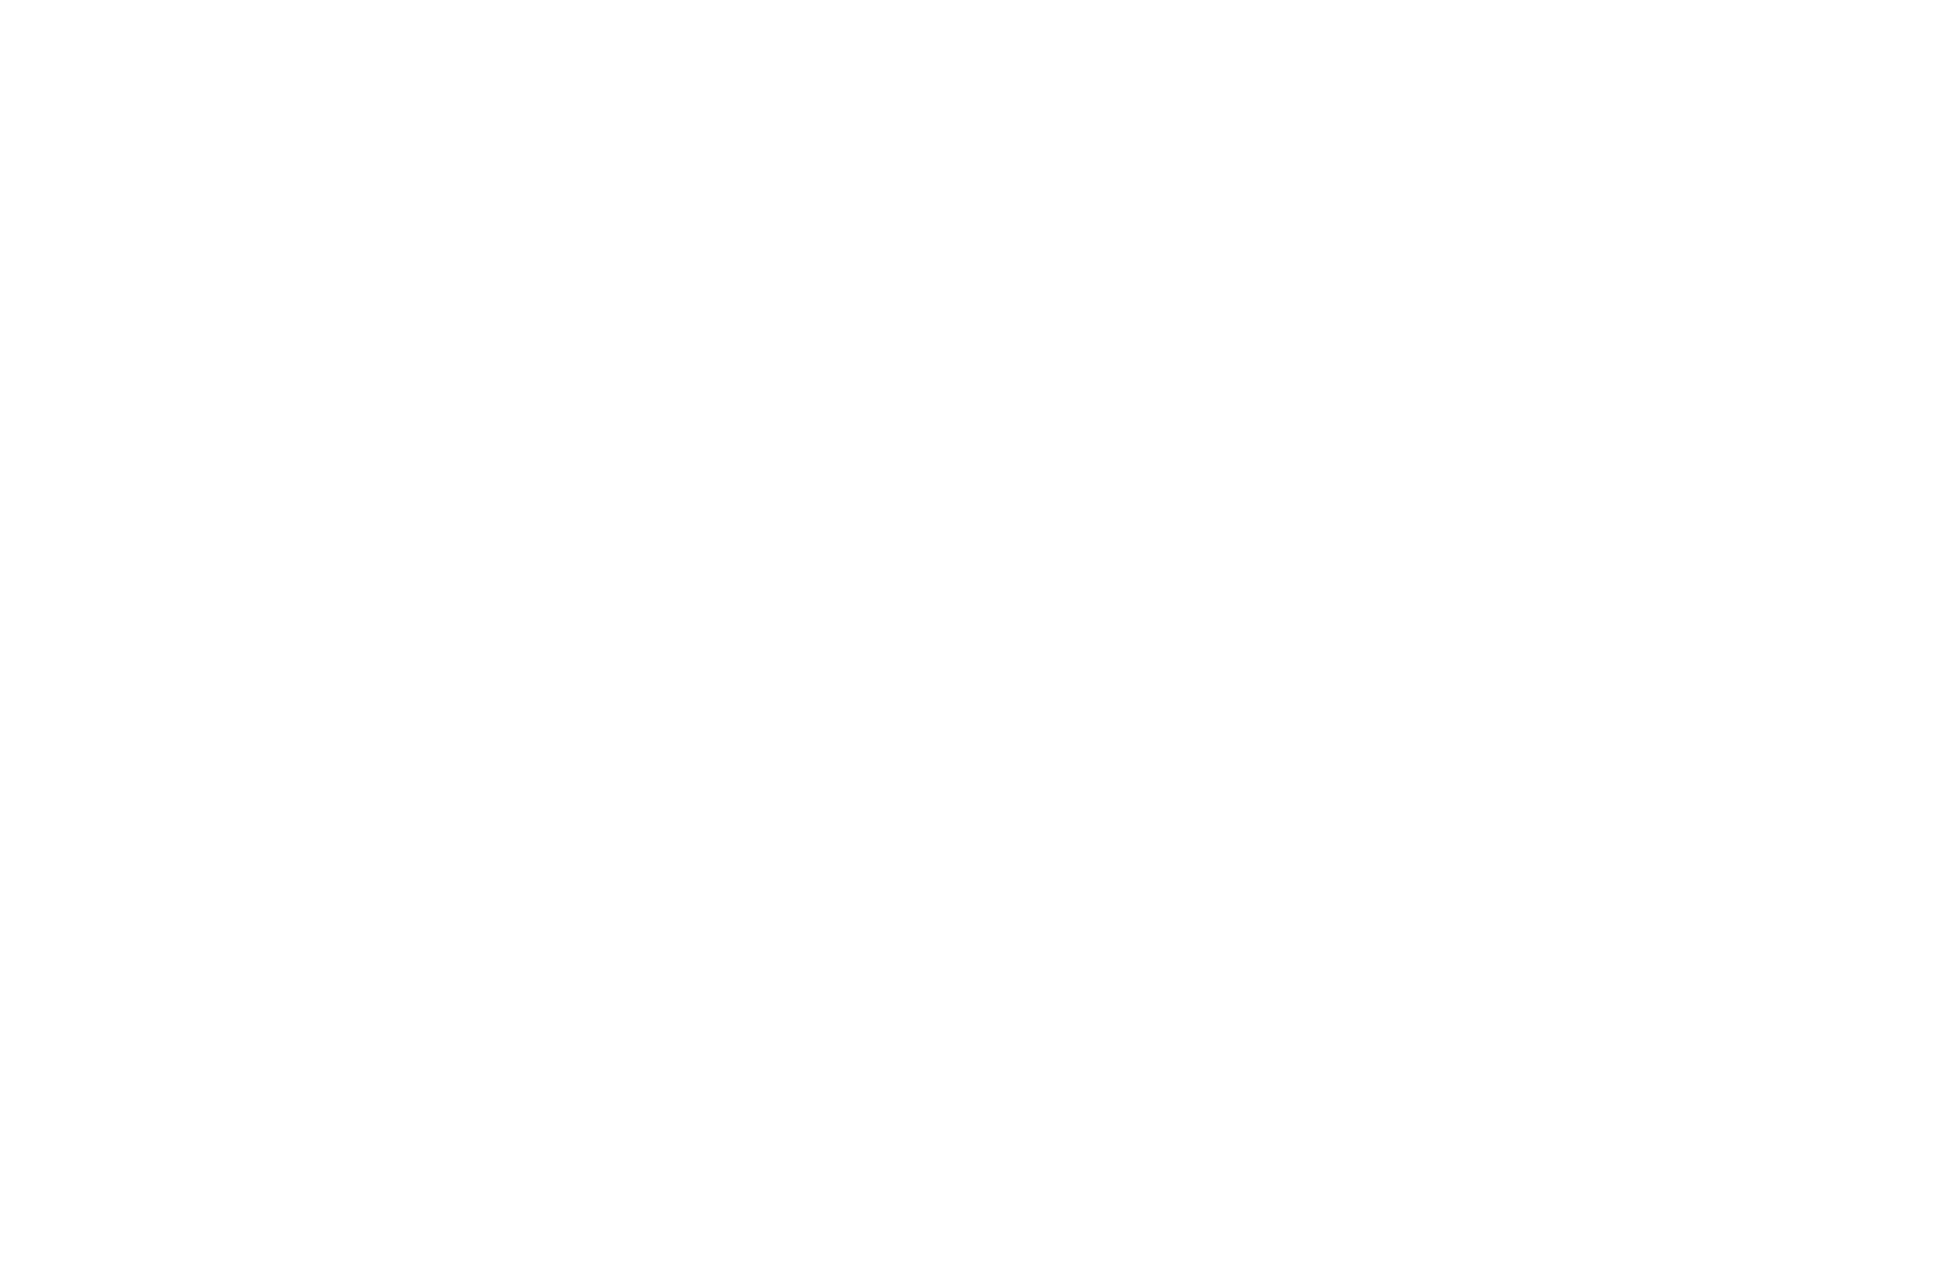

In [42]:
final_image_width = image_list[-1].shape[1]
final_image_height = image_list[-1].shape[0]
max_width = 20
max_height = 20*final_image_height/final_image_width 
fig, ax = plt.subplots()
ax.set_xlim(0,max_width)
ax.set_ylim(0, max_height)
ax.axis('off')
matplotlib.rcParams['figure.dpi']= 800

In [43]:
images = []
for i in range(len(image_list)):
    image_width = image_list[i].shape[1]
    image_height = image_list[i].shape[0]
    image = ax.imshow(image_list[i], extent = [0, max_width*image_width/final_image_width, 
                                               0, max_height*image_height/final_image_height])
    images.append([image])

In [44]:
animation_BFD = animation.ArtistAnimation(fig, images, interval=1000, blit=True,
                                repeat_delay=1000)
animation_BFD.save('BFD_DC.gif', writer='imagemagick', fps=1)

In [45]:
Image(url='BFD_DC.gif')

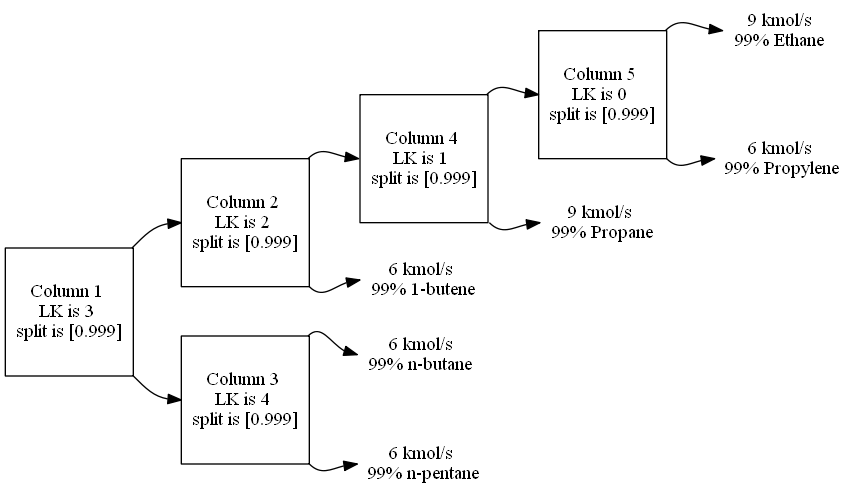

In [17]:
im = Image(G.create_png())
im

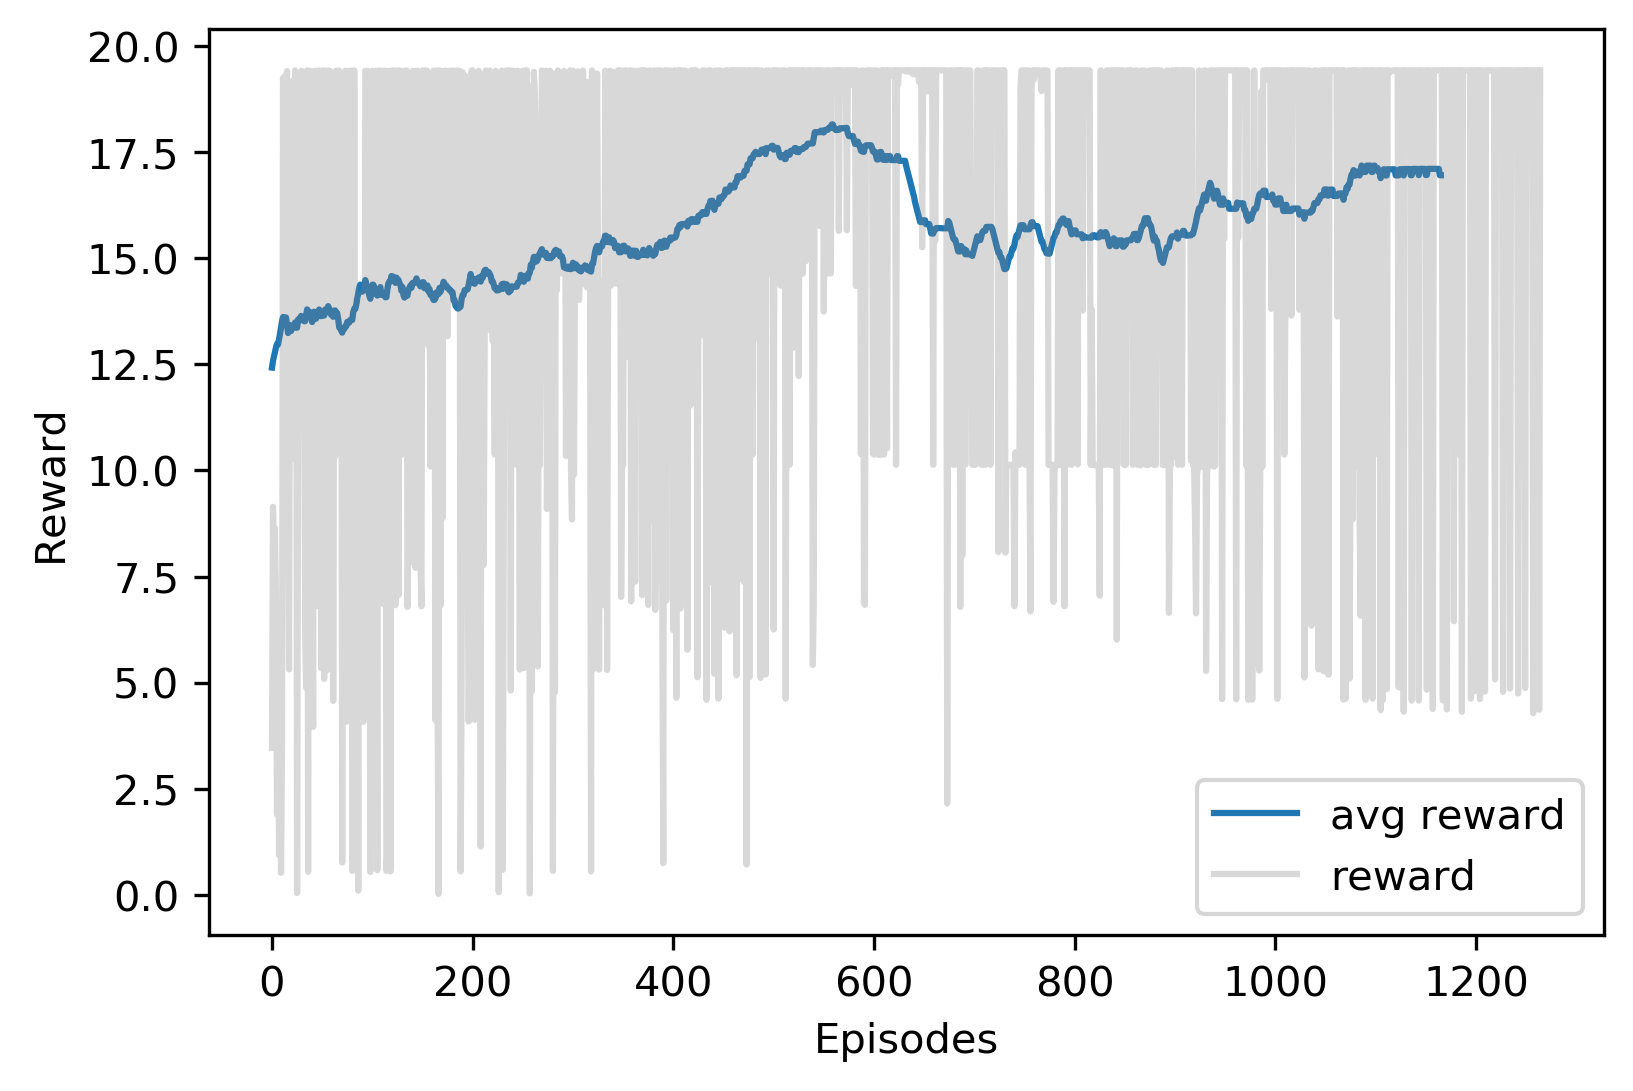

In [5]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
matplotlib.rcParams['figure.dpi']= 300
smoothed_rews = running_mean(reward_data, 100)
plt.plot(np.arange(np.shape(smoothed_rews)[0])[-len(smoothed_rews):], smoothed_rews)
plt.plot(np.arange(np.shape(reward_data)[0]),reward_data,color='grey', alpha=0.3)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend(["avg reward", "reward"], loc=4)
plt.savefig('Learning.png', bbox_inches='tight')

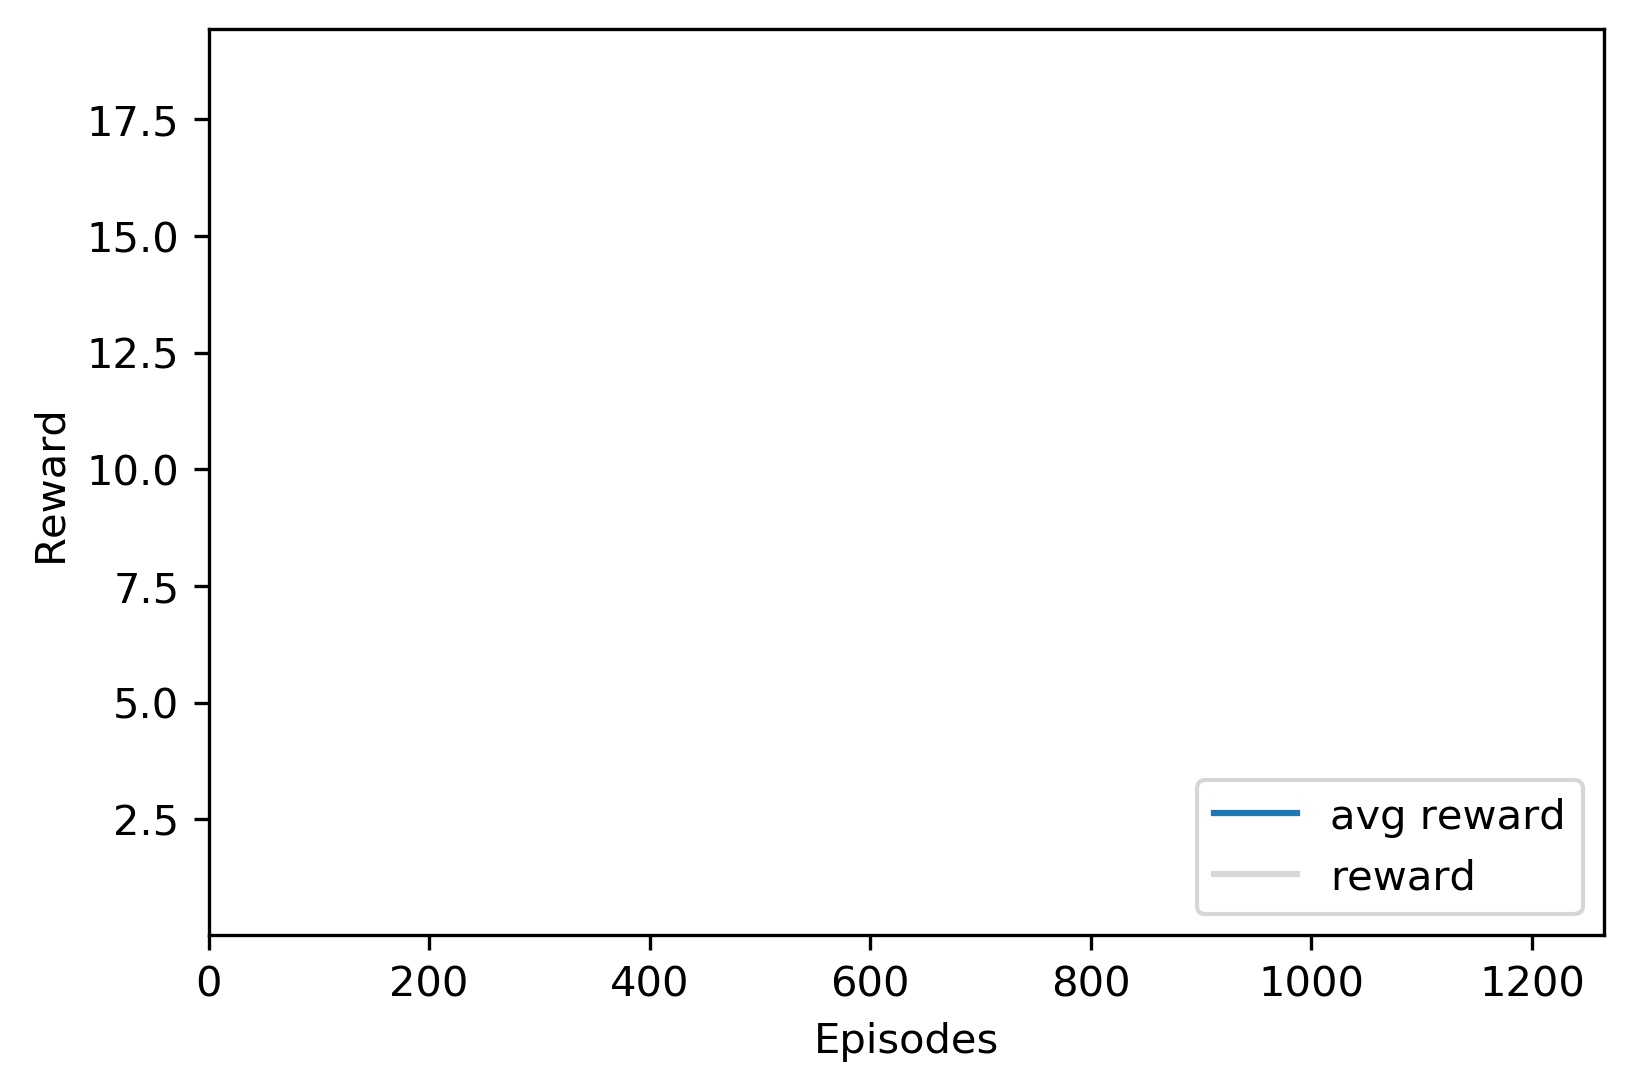

In [6]:
fig, ax = plt.subplots()
ax.set_xlabel("Episodes")
ax.set_ylabel("Reward")
ax.set_xlim(0,len(reward_data))
ax.set_ylim(reward_data.min(), reward_data.max())
interval = 30

lines = []
line1, = ax.plot([], [])
lines.append(line1)
line2, = ax.plot([], [],color='grey', alpha=0.3)
lines.append(line2)
ax.legend(["avg reward", "reward"], loc=4 )

def init():
    for line in lines:
        line.set_data([],[])
    return lines

def anim(i):
    smoothed_rews_ = smoothed_rews[0:i*interval]
    reward_data_ = reward_data[0:i*interval]
    lines[0].set_data(np.arange(np.shape(smoothed_rews_)[0])[-len(smoothed_rews_):], smoothed_rews_)
    lines[1].set_data(np.arange(np.shape(reward_data_)[0]),reward_data_)
    return lines

In [7]:
anim_Learn = animation.FuncAnimation(fig, anim, frames = round(len(smoothed_rews)/interval), init_func=init, interval = 200, blit = True)

In [8]:
rc('animation', html='html5')
anim_Learn

In [9]:
anim_Learn.save('Learning.gif', writer='imagemagick', fps = 10)
Image(url='c.gif')

In [12]:
reward = max(100 - 5 * env.PaybackPeriod, 0)

In [14]:
env.Profit

array([19431.96915903])

In [7]:
sum(env.capital_cost)

array([9.9027312e+09])

In [9]:
env.Performance_metric

array([177122.19178524])

In [13]:
env.revenue

55909.037122101894

In [12]:
sum(env.capital_cost)

array([9.9027312e+09])